In [1]:
import numpy as np
import os
import shutil
import json
import matplotlib.pyplot as plt
import joblib

import torch
import torch.nn as nn

import ray
from ray.tune.schedulers import ASHAScheduler
from ray import tune

from gnn_dataset import dataset, minmax_to_json, minmax_from_json
from gnn_training import train_loop, load_model0, best_model, select_node_feats, plot_result

ray.shutdown()
ray.init()

def train_looper(config_train, config):

    config["checkpoint_path"] = ""

    # train all
    freeze = []
    train_loop(config_train, config, epochs=600,
               patience=40, n_restart=1, freeze=freeze,
               report_result=True, ini_patience=300,
               node_features=config_train["num_features"],
              )
    return

def main(config, config_train_space):

    config_train_space = {
        "lr": tune.choice(config_train_space["lr"]),
        "batch_size": tune.choice(config_train_space["batch_size"]),
        "num_features": tune.choice(config_train_space["num_features"]),
        "graph_layers": tune.choice(config_train_space["graph_layers"]),
        "graph_hidden":tune.choice(config_train_space["graph_hidden"]),
        "net_layers": tune.choice(config_train_space["net_layers"]),
        "net_hidden": tune.choice(config_train_space["net_hidden"]),
        "aggr":tune.choice(config_train_space["aggr"]),
        "funnel_graph":tune.choice(config_train_space["funnel_graph"]),
        "funnel_net":tune.choice(config_train_space["funnel_net"]),    
        "graph_conv":tune.choice(config_train_space["graph_conv"]),
        "pooling":tune.choice(config_train_space["pooling"]),            
        }

    #def train_lambda(x): return train_looper(x, config)

    scheduler = ASHAScheduler(
        max_t=1000,
        grace_period=200,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_looper, config=config),
            resources={"cpu": 6}
        ),
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            scheduler=scheduler,
            num_samples=1,
        ),
        param_space=config_train_space,
    )
    results = tuner.fit()
    best_result = results.get_best_result("val_l1", "min", scope="all")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["val_loss"]))
    print("Best trial final validation MEAD: {}".format(
        best_result.metrics["val_l1"]))

    return best_result, config


# ref training:
config_train_space = {
    "lr": [0.002, 0.001, 0.005],
    "batch_size": [32, 64, 128, 256],

    "num_features": [1, 9],
    "num_layers": [3, 5, 7],
    "graph_hidden": [64, 128],

    "net_layers": [1, 2, 3],
    "net_hidden": [36, 64, 128],

    "aggr": ["mean","sum"],
    #"funnel_graph": [True],
    "funnel_net": [True, False],
    "graph_conv":["GraphConv","GCNConv","SAGEConv"],
    #"pool":["mean","sum"]
}

config_train_space = {
    "lr": [0.001],
    "batch_size": [32],

    "num_features": [9],
    "graph_layers": [ 5 ],
    "graph_hidden": [100],

    "net_layers": [ 2 ],
    "net_hidden": [48],

    "aggr": ["mean"],
    "funnel_graph": [True],
    "funnel_net": [ True],
    "graph_conv":["GraphConv"],
    #"pooling":["meanmax","addmax","meanmaxadd","mean","add","max"]
    "pooling":["meanmaxadd"]
}

config = {}

root = "/home/derwer/Desktop/PHD/Eyring_Architecture/graph_models/md_data_f02/"
data_csv = "raw_data.csv"

config["data_path_train"] = root + "/train/"
#config["data_path_train"] = root + "/val/"
config["data_path_val"] = root + "/val/"
config["data_path_test"] = root + "/test/"

config["data_csv_train"] = data_csv
config["data_csv_val"] = data_csv
config["data_csv_test"] = data_csv

config["build"] = "EyringEdgePool_ini"
config["build"] = "EyringEdgePool_graph_induce"

config["model_path"] = "/home/derwer/Desktop/PHD/Eyring_Architecture/graph_models/trainf02/"

if not os.path.exists(config["model_path"]):
    os.makedirs(config["model_path"])

best_result, config = main(config, config_train_space)


2025-02-04 23:44:09,332	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/derwer/ray_results/train_looper_2025-02-04_23-18-46' in 0.0041s.
2025-02-04 23:44:09,336	INFO tune.py:1041 -- Total run time: 1522.82 seconds (1522.77 seconds for the tuning loop).


Best trial config: {'lr': 0.001, 'batch_size': 32, 'num_features': 9, 'graph_layers': 5, 'graph_hidden': 100, 'net_layers': 2, 'net_hidden': 48, 'aggr': 'mean', 'funnel_graph': True, 'funnel_net': True, 'graph_conv': 'GraphConv', 'pooling': 'meanmaxadd'}
Best trial final validation loss: 0.0014653137186542153
Best trial final validation MEAD: 0.025991931557655334


(train_looper pid=11303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/derwer/ray_results/train_looper_2025-02-04_23-18-46/train_looper_005f7_00000_0_aggr=mean,batch_size=32,funnel_graph=True,funnel_net=True,graph_conv=GraphConv,graph_hidden=100,graph_l_2025-02-04_23-18-46/checkpoint_000000)


(train_looper pid=11303) early termination
(train_looper pid=11303) fin RE
(train_looper pid=11303) Finished Training 339


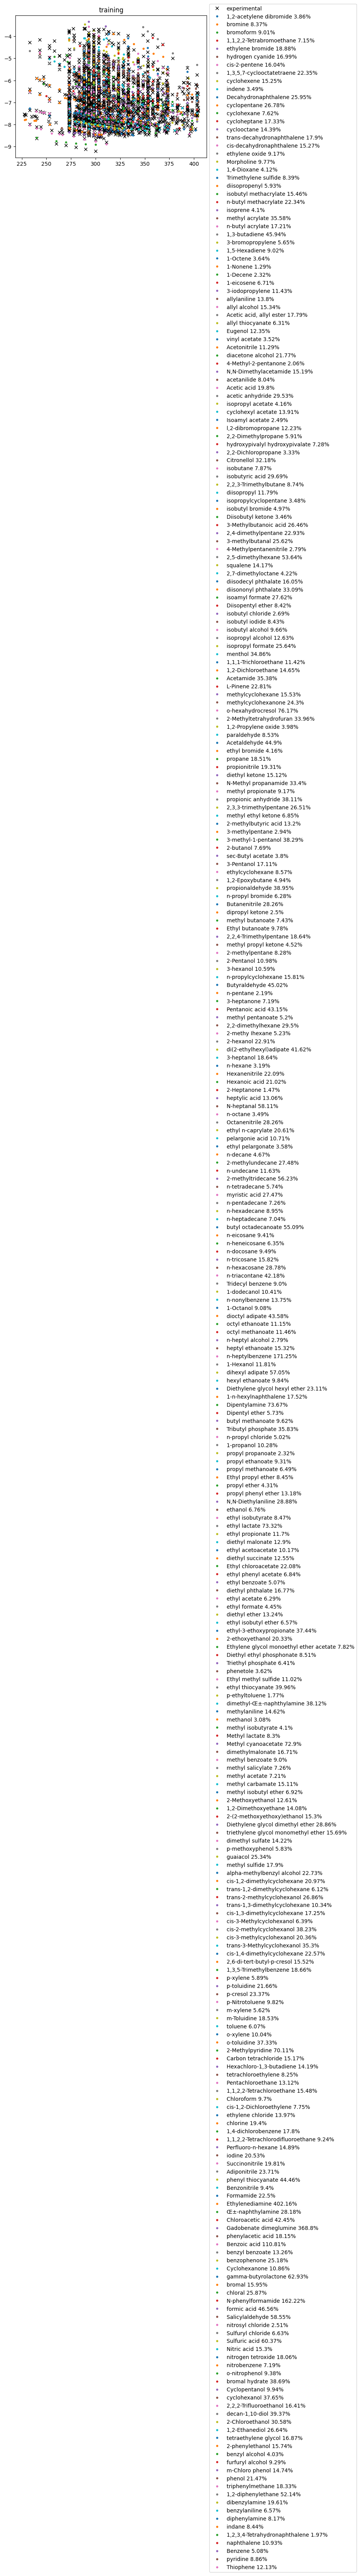

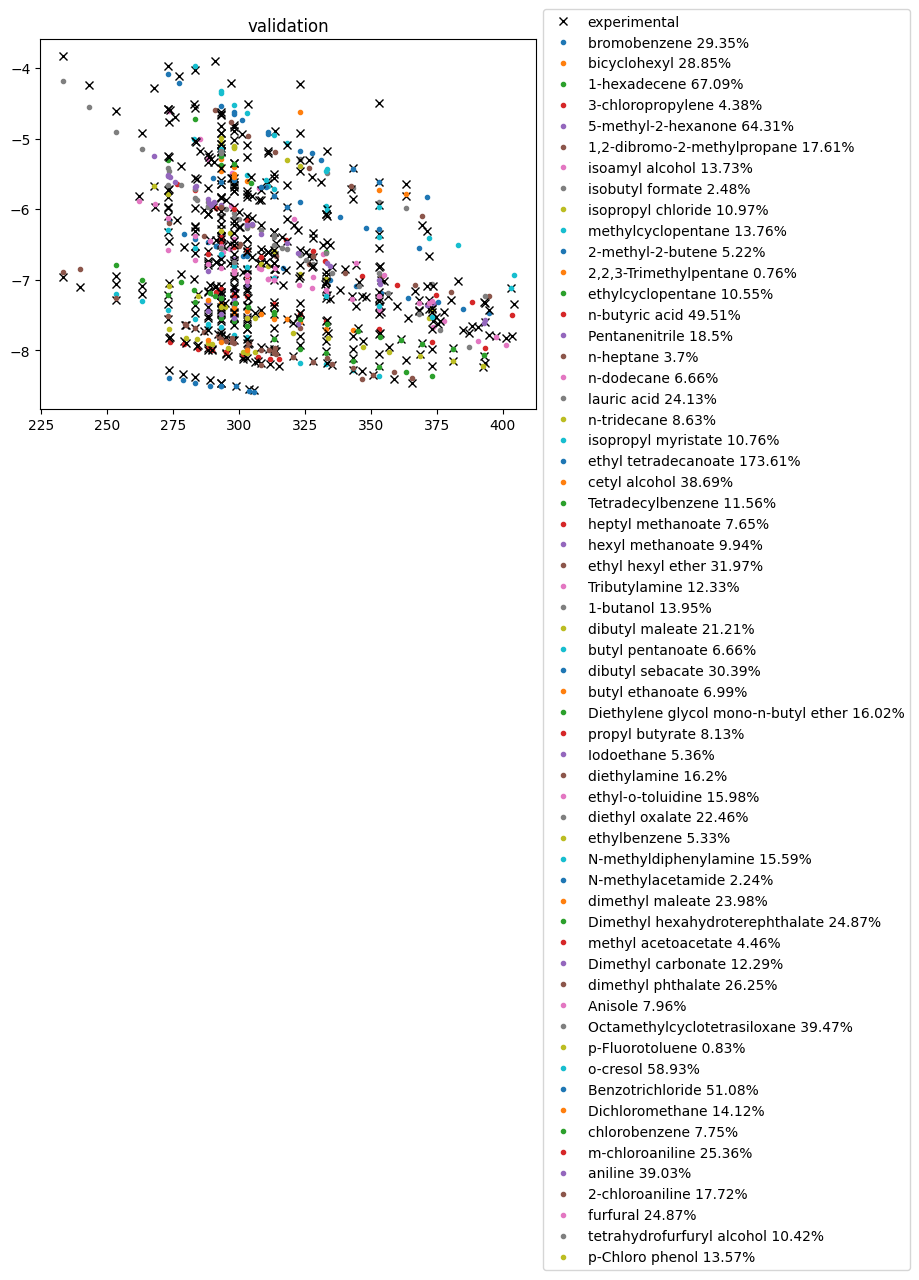

/home/derwer/Desktop/PHD/Eyring_Architecture/graph_models/gnn_training.py:374: UserWarning: Glyph 5 () missing from font(s) DejaVu Sans.
  plt.savefig(config["model_path"]+dd+".png", bbox_inches="tight")
/home/derwer/Desktop/PHD/Eyring_Architecture/graph_models/gnn_training.py:375: UserWarning: Glyph 5 () missing from font(s) DejaVu Sans.
  plt.savefig(config["model_path"]+dd+".pdf", bbox_inches="tight")
/home/derwer/Desktop/PHD/Eyring_Architecture/graph_models/gnn_training.py:375: UserWarning: Glyph 5 () missing from font(s) DejaVu Sans.
  plt.savefig(config["model_path"]+dd+".pdf", bbox_inches="tight")
/home/derwer/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 5 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


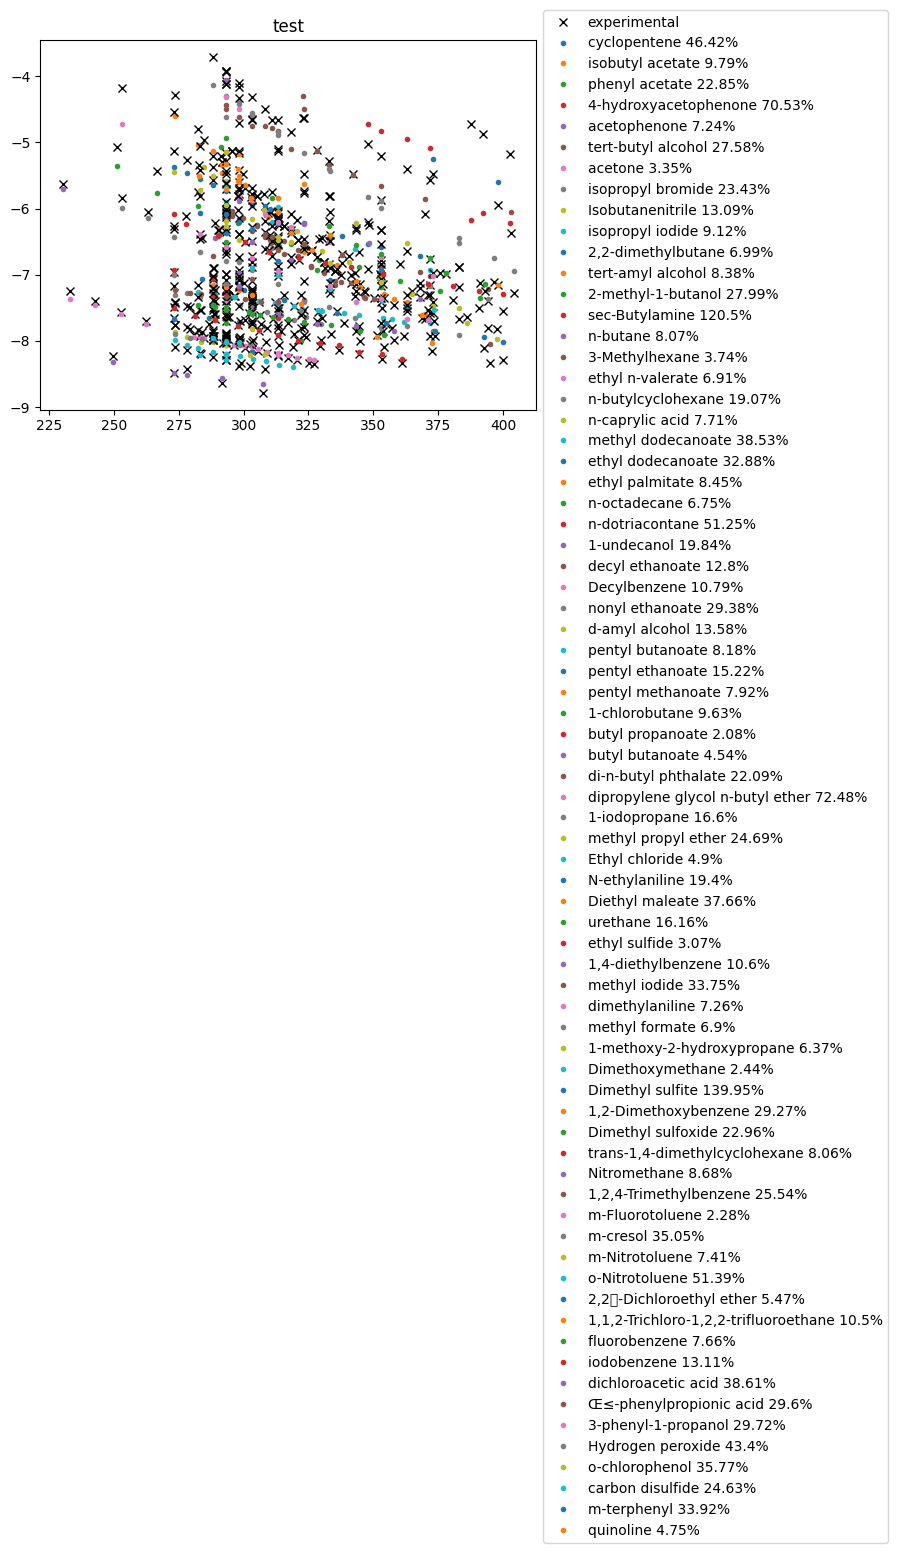

In [2]:
cname = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
final_result = {**best_result.metrics, **best_result.config, **config,
                "checkpoint_path": cname,
                }
model, data_train = best_model(final_result, exp_error=True)


training
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]

validation
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]

test
Scaler Info
[1.65272519e+00 4.67046863e+02 0.00000000e+00 2.00586634e+01
 0.00000000e+00 5.76559027e+00 1.12453452e+01 1.44340962e+04
 1.07076436e+01] [9.36831281e+00 3.57281551e+03 3.84000000e+00 3.91010693e+01
 3.82026750e+01 2.45797488e+01 4.36219041e+01 2.62303944e+05
 5.47573564e+01]
[1.65272519] [9.36831281]



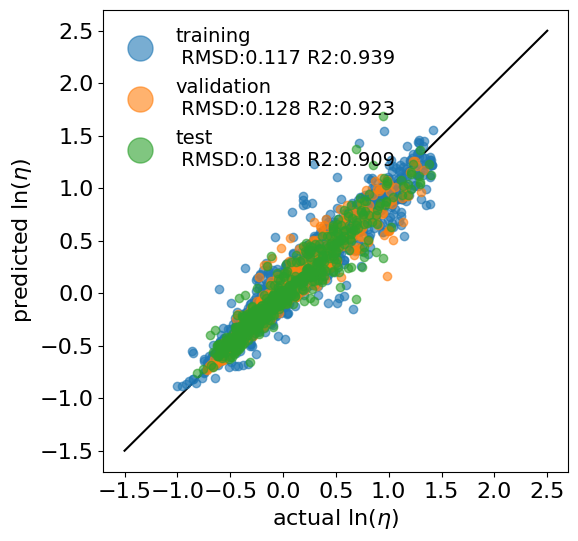

In [3]:

model, data_train = plot_result(final_result, )